In [1]:
import acquire
import env
import evaluate
import explore
import matplotlib.pyplot as plt
import numpy as np
import os.path
import prep
import pandas as pd
import seaborn as sns
import sklearn.linear_model
import sklearn.model_selection
import sklearn.feature_selection
import warnings

from math import sqrt
from scipy import stats
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import explained_variance_score as evs
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.formula.api import ols

%matplotlib inline

# limit all floats to 3 decimal places
pd.options.display.float_format = '{:.3f}'.format
warnings.filterwarnings('ignore')

#  Requirements and Planning
- write a SQL query to retreive data from the zillow database
- figure out state and county taxes for each property
- determine what drivers of the single unit property values for the "hot months" May and June
- build report for Zillow data science team

# Deliverables
#### A report (in the form of a presentation, both verbal and through a slides)
- vizualize tax distribution by county
- summarize your findings about the drivers of the single unit property values. 
- visualizations that support your main points.
- work must be reproducible by someone with their own env.py file.

# Acquire the Data
- call acquire_data() method from the acquire.py
- acquire.acquire_data() connects to the codeup_db
- runs a sql script to acquire the zillow data

In [2]:
df = acquire.acquire_data()

df

Acquiring data ...

- csv already exist

Data has been acquired


,bedroom_count,bathroom_count,total_sqft,tax_property_value,tax_amount,fips,county,state
0,2.000,3.000,1458.000,136104.000,2319.900,6037.000,Los Angeles,CA
1,1.000,2.000,1421.000,35606.000,543.690,6037.000,Los Angeles,CA
2,2.000,3.000,1650.000,614000.000,7673.190,6037.000,Los Angeles,CA
3,1.000,2.000,693.000,274237.000,3267.470,6037.000,Los Angeles,CA
4,0.000,0.000,1378.000,168828.000,2135.390,6037.000,Los Angeles,CA
...,...,...,...,...,...,...,...,...
15031,2.000,3.000,1575.000,506000.000,5417.500,6111.000,Ventura,CA
15032,2.000,3.000,1645.000,230986.000,2855.780,6111.000,Ventura,CA
15033,2.000,3.000,1308.000,255407.000,2788.680,6111.000,Ventura,CA
15034,2.500,4.000,2314.000,485364.000,9549.080,6111.000,Ventura,CA


# Prepair the Data
- call clean_df() method from the prep.py
- prep.clean_df() receives the zillow dataframe
- averages out any empty bathroom or bedroom count
- drops an row that is null
- calculates the tax rate for each property
- sets all fips to integer type

In [3]:
df = prep.clean_df(df)
df

Cleaning data ...

- dropped all rows containing a null
- created tax_rate column

Zillow_df cleaned and ready for exploration


,bedroom_count,bathroom_count,total_sqft,tax_property_value,tax_amount,county,state,tax_rate
0,2.000,3.000,1458.000,136104.000,2319.900,Los Angeles,CA,0.017
1,1.000,2.000,1421.000,35606.000,543.690,Los Angeles,CA,0.015
2,2.000,3.000,1650.000,614000.000,7673.190,Los Angeles,CA,0.012
3,1.000,2.000,693.000,274237.000,3267.470,Los Angeles,CA,0.012
4,0.000,0.000,1378.000,168828.000,2135.390,Los Angeles,CA,0.013
...,...,...,...,...,...,...,...,...
15031,2.000,3.000,1575.000,506000.000,5417.500,Ventura,CA,0.011
15032,2.000,3.000,1645.000,230986.000,2855.780,Ventura,CA,0.012
15033,2.000,3.000,1308.000,255407.000,2788.680,Ventura,CA,0.011
15034,2.500,4.000,2314.000,485364.000,9549.080,Ventura,CA,0.020


## Tax Distribution by County

In [4]:
mask1 = df.county == 'Los Angeles'
mask2 = df.county == 'Orange'
mask3 = df.county == 'Ventura'
lac = df[mask1]
oc = df[mask2]
vac = df[mask3]

### Tax Rate Distribution Visual

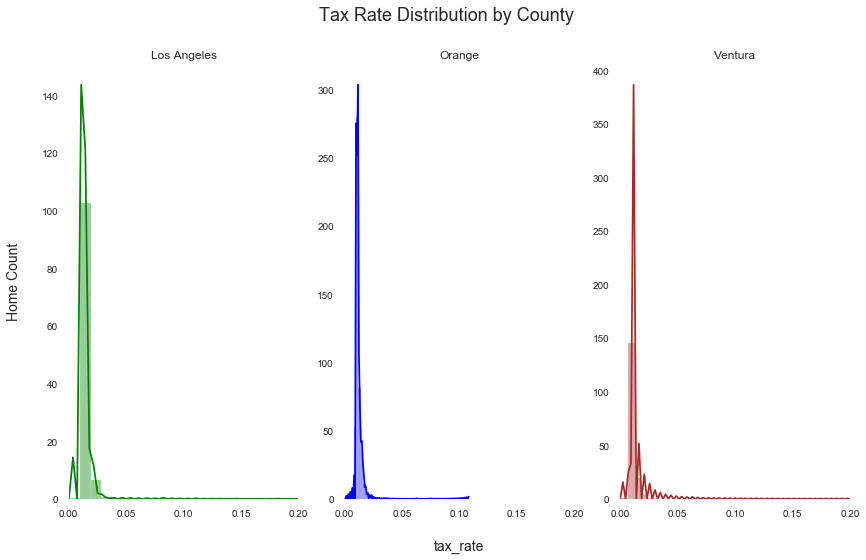

In [5]:
f, axes = plt.subplots(1, 3, figsize=(14, 8), sharex=True)
sns.despine(left=True)
plt.suptitle('Tax Rate Distribution by County', fontsize=18)
ax1 = sns.distplot(lac.tax_rate, kde=True, color='green', ax=axes[0])
ax2 = sns.distplot(oc.tax_rate, kde=True, color='blue', ax=axes[1])
ax3 = sns.distplot(vac.tax_rate, kde=True, color='brown', ax=axes[2])
ax1.title.set_text('Los Angeles')
ax2.title.set_text('Orange')
ax3.title.set_text('Ventura')
ax1.set_ylabel('Home Count\n', fontsize=14)
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.set_xlabel('')
ax2.set_xlabel('\ntax_rate', fontsize=14)
ax3.set_xlabel('')
plt.xlim(0, 0.2)
plt.show()

## Train Test Split

In [6]:
train, test = sklearn.model_selection.train_test_split(df, train_size=.85, random_state=22)
print(train.shape)
print(test.shape)

(12759, 8)
(2252, 8)


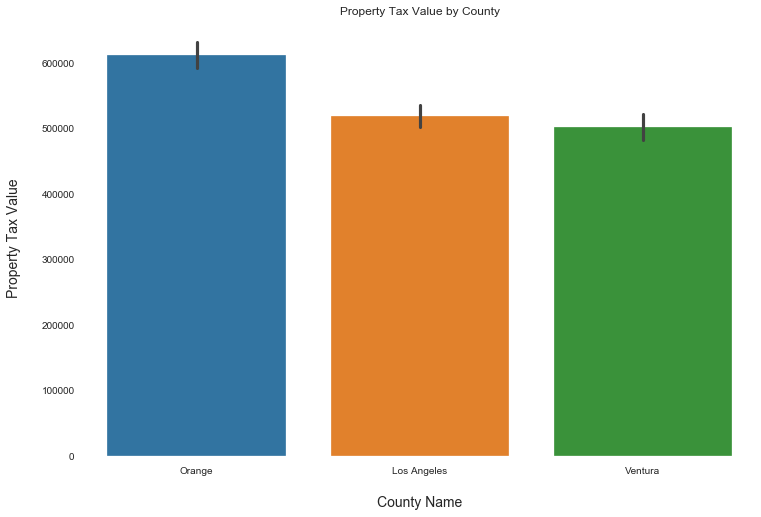

In [35]:
plt.figure(figsize=(12, 8))
plt.title('Property Tax Value by County')
y = train.tax_property_value
x = train.county
sns.barplot(x, y)
plt.xlabel('\nCounty Name', fontsize=14)
plt.ylabel('Property Tax Value\n', fontsize=14)
plt.show()

# Explore the data

In [36]:
# explore.plot_variable_pairs(df, hue=None)

## My Hypotheses:

- $𝐻_0$: there is no linear correlation between any of the values and tax_property_value
- $𝐻_𝑎$ : there is linear correlation between at least one of the values and tax_property_value

In [37]:
y = train.tax_property_value

# change first three to little x
x_bath = train.bathroom_count
# bath_corr, bath_p = explore.get_pearsonr(x_bath, y)
x_bed = train.bedroom_count
x_sqft = train.total_sqft
X_all_three = train[['bathroom_count', 'bedroom_count', 'total_sqft']]

In [38]:
X_all_three

,bathroom_count,bedroom_count,total_sqft
13171,5.000,4.500,4211.000
8395,4.000,2.000,1541.000
14203,3.000,2.000,2208.000
5539,3.000,2.000,1667.000
3090,2.000,1.000,952.000
...,...,...,...
5482,5.000,4.000,2771.000
8555,3.000,3.000,2085.000
13122,4.000,3.000,3850.000
6282,5.000,4.000,3048.000


### Correlations between features and propery values

In [39]:
bath_corr, bath_p = explore.get_pearsonr(x_bath, y)
bed_corr, bed_p = explore.get_pearsonr(x_bed, y)
sqrt_corr, sqrt_p = explore.get_pearsonr(x_sqft, y)

In [40]:
print(f'bath_corr: {bath_corr}, bath_p {bath_p}')
print(f'bed_corr: {bed_corr}, bed_p {bed_p}')
print(f'sqrt_corr: {sqrt_corr}, sqrt_p {sqrt_p}')

bath_corr: 0.28056662981849, bath_p 1.9047361356020748e-229
bed_corr: 0.5155792260019061, bed_p 0.0
sqrt_corr: 0.6030768006911846, sqrt_p 0.0


- With a higher correlation of the three, sqft is the best
- What about all three

In [41]:
predictions = pd.DataFrame({
    'county': train.county,
    'actual': train.tax_property_value
})

In [42]:
# change first three to little x
X_bathrm_count = train[['bathroom_count']]
X_bedrm_count = train[['bedroom_count']]
X_sqft = train[['total_sqft']]
X_all_three = train[['bathroom_count', 'bedroom_count', 'total_sqft']]

y = train.tax_property_value

### Linear Regession

In [15]:
predictions['baseline'] = y.mean()

In [16]:
lm = sklearn.linear_model.LinearRegression()

In [17]:
bathroom_lm = lm.fit(X_bathrm_count, y)
predictions['bathroom_ct_lm'] = bathroom_lm.predict(X_bathrm_count)

bedroom_lm = lm.fit(X_bedrm_count, y)
predictions['bedroom_ct_lm'] = bedroom_lm.predict(X_bedrm_count)

sqft_lm = lm.fit(X_sqft, y)
predictions['sqft_lm'] = sqft_lm.predict(X_sqft)

all_three_lm = lm.fit(X_all_three, y)
predictions['all_three_lm'] = all_three_lm.predict(X_all_three)

In [18]:
predictions

,county,actual,baseline,bathroom_ct_lm,bedroom_ct_lm,sqft_lm,all_three_lm
13171,Orange,1267425.000,543023.912,916936.329,1356303.396,1555697.155,1516597.022
8395,Los Angeles,343170.000,543023.912,695041.049,420037.680,363341.809,229154.062
14203,Ventura,424336.000,543023.912,473145.769,420037.680,661207.358,701214.684
5539,Los Angeles,576000.000,543023.912,473145.769,420037.680,419610.264,437093.374
3090,Los Angeles,21902.000,543023.912,251250.488,45531.393,100309.113,182309.078
...,...,...,...,...,...,...,...
5482,Los Angeles,157153.000,543023.912,916936.329,1169050.252,912629.104,787505.689
8555,Los Angeles,1085000.000,543023.912,473145.769,794543.966,606278.629,693304.389
13122,Orange,975915.000,543023.912,695041.049,794543.966,1394483.567,1408569.135
6282,Los Angeles,964487.000,543023.912,916936.329,1169050.252,1036330.389,922739.705


#### Plot the Predictions

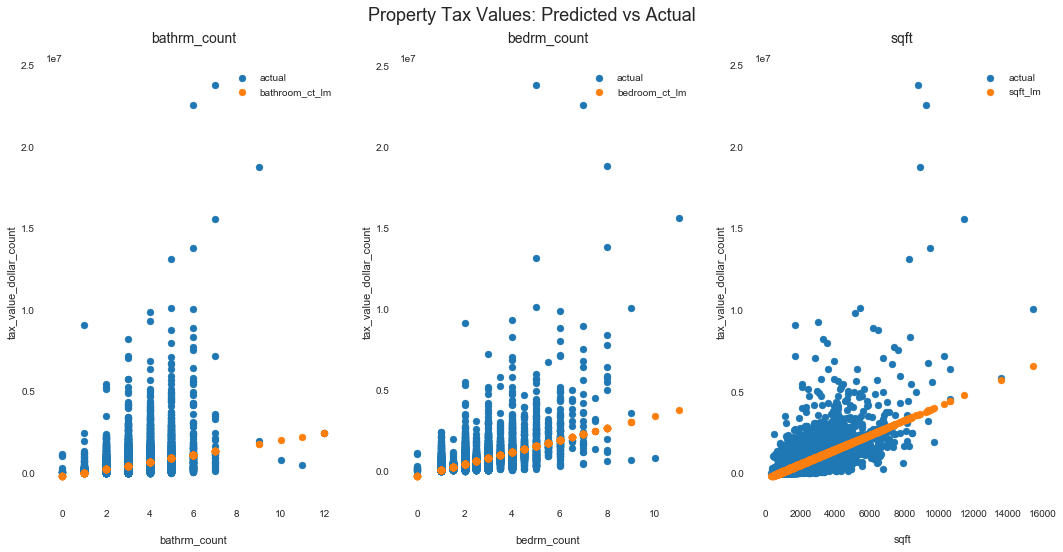

In [19]:
plt.figure(figsize=(18,8))
plt.suptitle('Property Tax Values: Predicted vs Actual\n', fontsize=18)

# Figure 1
plt.subplot(1, 3, 1)
plt.title('bathrm_count\n', fontsize=14)
plt.scatter(X_bathrm_count, predictions.actual, label='actual')
plt.scatter(X_bathrm_count, predictions.bathroom_ct_lm, label='bathroom_ct_lm')
plt.xlabel('\nbathrm_count')
plt.ylabel('tax_value_dollar_count')
plt.legend()

# Figure 2
plt.subplot(1, 3, 2)
plt.title('bedrm_count\n', fontsize=14)
plt.scatter(X_bedrm_count, predictions.actual, label='actual')
plt.scatter(X_bedrm_count, predictions.bedroom_ct_lm, label='bedroom_ct_lm')
plt.xlabel('\nbedrm_count')
plt.ylabel('tax_value_dollar_count')
plt.legend()

# Figure 3
plt.subplot(1, 3, 3)
plt.title('sqft\n', fontsize=14)
plt.scatter(X_sqft, predictions.actual, label='actual')
plt.scatter(X_sqft, predictions.sqft_lm, label='sqft_lm')
plt.xlabel('\nsqft')
plt.ylabel('tax_value_dollar_count')
plt.legend()

plt.show()

# Train the Model

In [20]:
RMSE_model = pd.DataFrame({
    'actual': train.tax_property_value
})

In [21]:
SSE, ESS, TSS, MSE, RMSE_bath = evaluate.regression_errors(predictions.actual, predictions.bathroom_ct_lm)
RMSE_model['RMSE_bathroom'] = RMSE_bath

In [22]:
SSE, ESS, TSS, MSE, RMSE_bed = evaluate.regression_errors(predictions.actual, predictions.bedroom_ct_lm)
RMSE_model['RMSE_bedroom'] = RMSE_bed

In [23]:
SSE, ESS, TSS, MSE, RMSE_sqft = evaluate.regression_errors(predictions.actual, predictions.sqft_lm)
RMSE_model['RMSE_sqft'] = RMSE_sqft

In [24]:
SSE, ESS, TSS, MSE, RMSE_all_3 = evaluate.regression_errors(predictions.actual, predictions.all_three_lm)
RMSE_model['RMSE_all_three'] = RMSE_all_3

In [25]:
SSE_baseline, MSE_baseline, RMSE_baseline = evaluate.baseline_mean_errors(predictions.actual, predictions.baseline)
RMSE_model['RMSE_baseline'] = RMSE_baseline

In [26]:
print(evaluate.bettter_than_baeline(RMSE_all_3, RMSE_baseline))

Model is better than baseline
None


- The best RMSE model consist of using all three features; bathroom count, bedroom count, and sqft

# Evaluating the Model

In [43]:
test_baseline = test.tax_property_value.mean()

In [44]:
# change first three to little x
X_test = test[['bathroom_count', 'bedroom_count', 'total_sqft']]

y = test.tax_property_value

In [45]:
test_predictions = pd.DataFrame({
    
    'actual': test.tax_property_value
})

In [46]:
test_predictions['baseline'] = test_baseline
test_predictions['bath_bed_sqft_lm'] = all_three_lm.predict(X_test)

In [47]:
SSE_baseline, MSE_baseline, RMSE_baseline = evaluate.baseline_mean_errors(test_predictions.actual, test_predictions.baseline)

In [48]:
SSE, ESS, TSS, MSE, RMSE = evaluate.regression_errors(test_predictions.actual, test_predictions.bath_bed_sqft_lm)

In [49]:
test_baseline, RMSE, RMSE_baseline

(531751.1079040853, 496192.4014266531, 631300.9469932646)

In [50]:
print(evaluate.bettter_than_baeline(RMSE, RMSE_baseline))

Model is better than baseline
None
